In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Get and Load the Pima Indians Diabetes dataset

We download the data from an nrvis repository. And we load it into a pandas dataframe.

In [2]:
!wget http://nrvis.com/data/mldata/pima-indians-diabetes.csv

--2021-01-07 20:22:24--  http://nrvis.com/data/mldata/pima-indians-diabetes.csv
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23279 (23K) [text/csv]
Saving to: ‘pima-indians-diabetes.csv.7’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.02s   

2021-01-07 20:22:25 (1.16 MB/s) - ‘pima-indians-diabetes.csv.7’ saved [23279/23279]



In [3]:
df = pd.read_csv('pima-indians-diabetes.csv',header=None)
# 0. Number of times pregnant
# 1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
# 2. Diastolic blood pressure (mm Hg)
# 3. Triceps skin fold thickness (mm)
# 4. 2-Hour serum insulin (mu U/ml)
# 5. Body mass index (weight in kg/(height in m)^2)
# 6. Diabetes pedigree function
# 7. Age (years)
# 8. Class variable (0 or 1)
df.columns = ["NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", "BMI", "DiPedFunc", "Age", "HasDiabetes"]

--------------------------------------------------------------------

# Define Helper Functions

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Train using a Logistic Regression

We use a simple Logistic Regression model to train our datasets

In [5]:
def train_lr(df_train):
  X = df_train.iloc[:,range(8)]
  Y = df_train.iloc[:,8]

  X = sm.add_constant(X)

  model = sm.Logit(Y, X).fit()

  print(model.summary())

  return model

#### Predict and generate accuracry score

We use our model to generate prediction probabilites (range 0-1) on our test dataset. We use prediction probability >= 0.5 to assess if the model predicts the individual has diabetes.

We then compare if the individual actually had diabetes and generate an accurancy for our model.

In [6]:
def predict_and_evaluate(df_test, model):
  y_pred = model.predict(sm.add_constant(df_test.iloc[:,range(8)]))
  y_pred.name='prediction'
  res = pd.concat([df_test, y_pred],axis=1)

  res['PredDiabetes'] = np.where(res['prediction'] >= 0.5, 1, 0)

  acc = accuracy_score(res['HasDiabetes'], res['PredDiabetes'])
  print('\n')
  print(f'Accuracy = {acc} for baseline Logistic Regression')

  return res

#### Plot top-k confident and correct/incorrect

We create side-by-side plots of the top-k samples where the model was confident in its prediction, with the first plot being most confident yet incorrect prediction and the second being the most confident and correct prediction.

Such plots can be used to analyze which variables might be leading the model astray in extreme situations.

In [7]:
def plot_topk(res, k=5):
  fig, ax = plt.subplots(1,2,figsize=(10,6))
  ((res.loc[res['HasDiabetes']==0].sort_values('prediction',ascending=False).head(k) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[0],legend=False,title='confident and incorrect')
  ((res.loc[res['HasDiabetes']==1].sort_values('prediction',ascending=False).head(k) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[1],title='confident and correct')
  plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
  plt.show()

### Runner

This function runs our training and testing

In [8]:
def train_and_test(df_train, df_test):
  model = train_lr(df_train)
  res = predict_and_evaluate(df_test, model)
  plot_topk(res)

--------------------------------------------------------------------

# Baseline

We train a baseline LR model without any straifications on the features

Optimization terminated successfully.
         Current function value: 0.483040
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Jan 2021   Pseudo R-squ.:                  0.2607
Time:                        20:22:25   Log-Likelihood:                -296.59
converged:                       True   LL-Null:                       -401.18
Covariance Type:            nonrobust   LLR p-value:                 7.418e-41
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.1937      0.780    -10.507      0.000      -9.722      -6.665
NumTimesPrg       0.

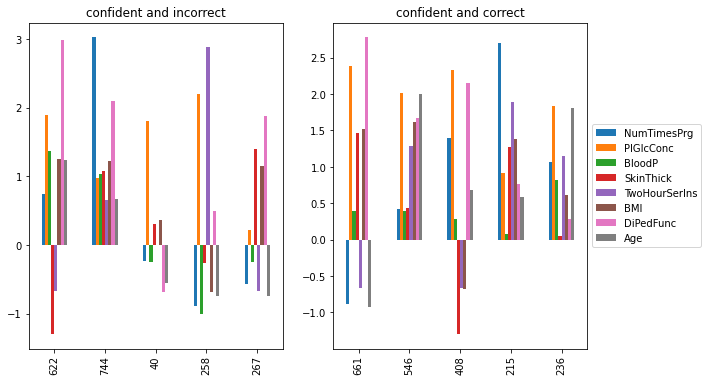

In [9]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=0)

train_and_test(df_train, df_test)

We find our simple Logistic Regression model performs decently well at predicting diabetes among this population

--------------------------------------------------------------------

# Straification on Subpopulations

Now we judge the model's accuracy on different stratifications of the features. We choose 3 subpopulations based on younger/older age and healthy/unhealthy BMI, as they demonstrate good predictive power from the baseline model:

1 - Younger (Age < 40) and non-obese BMI (BMI < 30)

2 - Younger (Age < 40) and obese BMI (BMI >= 30)

3 - Obese BMI only (BMI >= 30)


We also confirm these subpopulations have sufficient counts (~ >100) to avoid too few data points during training and testing

In [10]:
pop1_df = df[(df['Age'] < 40) & (df['BMI'] < 30)]
pop2_df = df[(df['Age'] < 40) & (df['BMI'] >= 30)]
pop3_df = df[(df['BMI'] >= 30)]

print(len(pop1_df))
print(len(pop2_df))
print(len(pop3_df))

230
331
472


# Stratification #1

Optimization terminated successfully.
         Current function value: 0.197116
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                  184
Model:                          Logit   Df Residuals:                      175
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Jan 2021   Pseudo R-squ.:                  0.4066
Time:                        20:22:26   Log-Likelihood:                -36.269
converged:                       True   LL-Null:                       -61.123
Covariance Type:            nonrobust   LLR p-value:                 4.652e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -10.3614      2.652     -3.906      0.000     -15.560      -5.163
NumTimesPrg       0.

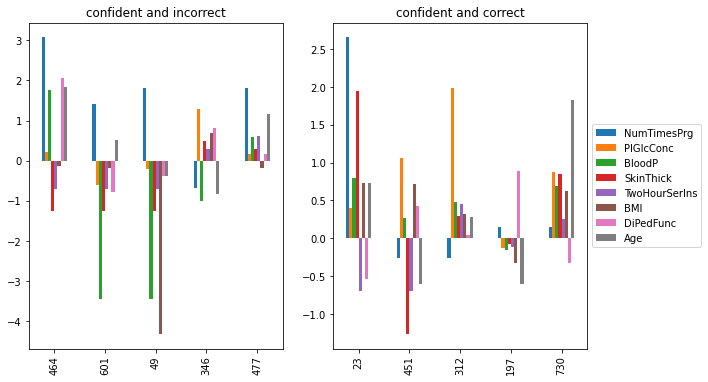

In [11]:
pop1_df_train, pop1_df_test = train_test_split(pop1_df, test_size=0.2, random_state=0)

train_and_test(pop1_df_train, pop1_df_test)

# Stratification #2

Optimization terminated successfully.
         Current function value: 0.489300
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                  264
Model:                          Logit   Df Residuals:                      255
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Jan 2021   Pseudo R-squ.:                  0.2736
Time:                        20:22:26   Log-Likelihood:                -129.18
converged:                       True   LL-Null:                       -177.84
Covariance Type:            nonrobust   LLR p-value:                 1.504e-17
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.7150      1.589     -4.855      0.000     -10.830      -4.600
NumTimesPrg      -0.

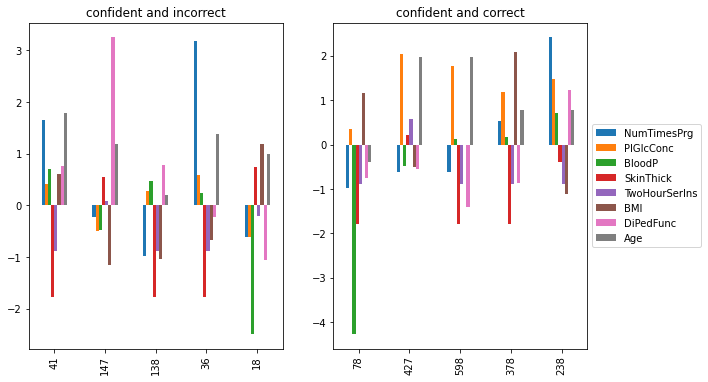

In [12]:
pop2_df_train, pop2_df_test = train_test_split(pop2_df, test_size=0.2, random_state=0)

train_and_test(pop2_df_train, pop2_df_test)

# Stratification #3

Optimization terminated successfully.
         Current function value: 0.529617
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                  377
Model:                          Logit   Df Residuals:                      368
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Jan 2021   Pseudo R-squ.:                  0.2345
Time:                        20:22:27   Log-Likelihood:                -199.67
converged:                       True   LL-Null:                       -260.84
Covariance Type:            nonrobust   LLR p-value:                 1.087e-22
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.7914      1.168     -5.816      0.000      -9.080      -4.503
NumTimesPrg       0.

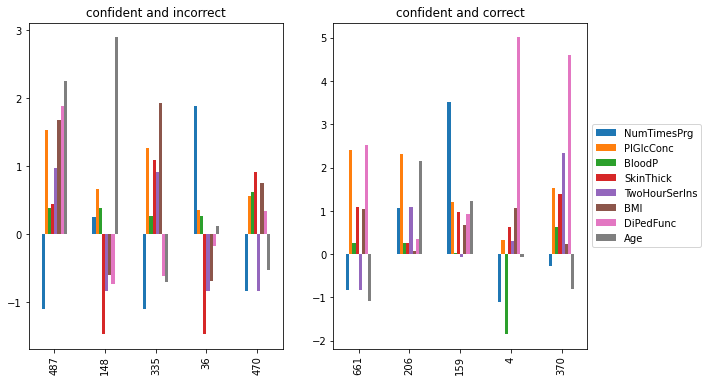

In [13]:
pop3_df_train, pop3_df_test = train_test_split(pop3_df, test_size=0.2, random_state=0)

train_and_test(pop3_df_train, pop3_df_test)

# Analysis of good stratifications

We see from these examples that each chosen stratification generates Logistic Regression models that perform fairly well (70% to 100% accuracy).

This indicates that stratifications of interesting features allows the model to have better (or similar) performance to the whole population (baseline) model.

--------------------------------------------------------------------

# Analysis of bad stratifications

Now we stratify on the same features but chooose cutoffs that are more extreme and less sensical to the problem (predicting diabetes).

Optimization terminated successfully.
         Current function value: 0.348875
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                   37
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Jan 2021   Pseudo R-squ.:                  0.4740
Time:                        20:22:27   Log-Likelihood:                -12.908
converged:                       True   LL-Null:                       -24.541
Covariance Type:            nonrobust   LLR p-value:                  0.003040
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4976     10.866      0.046      0.963     -20.800      21.795
NumTimesPrg      -0.

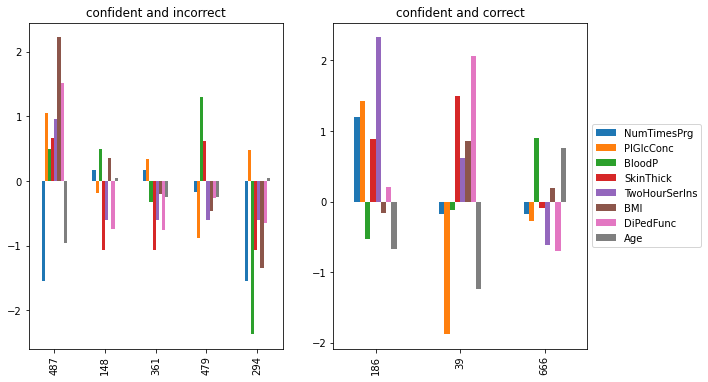

In [14]:
bad_pop_df = df[(df['Age'] > 55) & (df['BMI'] > 20)]

bad_pop_df_train, bad_pop_df_test = train_test_split(bad_pop_df, test_size=0.2, random_state=0)

train_and_test(bad_pop_df_train, bad_pop_df_test)

We see that the trained model does not perform well, and is even worse at predicting diabetes than chance.